In [11]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [13]:
data_train = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/train.csv')
data_test = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/test.csv')

In [15]:
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


<h1>Check for missing values</h1>

In [17]:
print('Missing values in train dataset')
print(data_train.isnull().sum())

Missing values in train dataset
PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64


In [19]:
print('Unique values in train dataset')
print(data_train.nunique())

Unique values in train dataset
PassengerId    100000
Survived            2
Pclass              3
Name            92144
Sex                 2
Age               173
SibSp               7
Parch               8
Ticket          75331
Fare            15935
Cabin           26992
Embarked            3
dtype: int64


In [21]:
print('Missing values in test dataset')
print(data_test.isnull().sum())

Missing values in test dataset
PassengerId        0
Pclass             0
Name               0
Sex                0
Age             3487
SibSp              0
Parch              0
Ticket          5181
Fare             133
Cabin          70831
Embarked         277
dtype: int64


In [23]:
print('Missing values in test dataset')
print(data_test.nunique())

Missing values in test dataset
PassengerId    100000
Pclass              3
Name            90808
Sex                 2
Age               159
SibSp               7
Parch               8
Ticket          75432
Fare            16554
Cabin           25216
Embarked            3
dtype: int64


In [25]:
def titanic_preprocessing(dataset):
    # Delete useless columns
    dataset = dataset.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    # Why I want to delete them?
    # PassengerId, Name - those feature will bring nothing to our prediction
    # Ticket - to many unique values
    # Cabin - to many missing values

    # Fill Age column with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    
    # Fill Embarked with most occuring values
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    
    # Fill Fare column with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

    return dataset

In [27]:
def titanic_feature_engineering(dataset):
    # Create dummy variables
    columns = ['Embarked']
    dummy = pd.get_dummies(dataset['Embarked'], dtype=np.int32)
    dataset = pd.concat([dataset, dummy], axis=1)
    dataset.drop(['Embarked'], axis=1, inplace=True)

    dataset['Sex_dummy'] = dataset['Sex'].map({'male': 0, 'female': 1})
    dataset.drop(['Sex'], axis=1, inplace=True)
    
    return dataset 

In [29]:
def dataset_preparation(dataset):
    dataset = titanic_preprocessing(dataset)
    dataset = titanic_feature_engineering(dataset)
    return dataset

In [31]:
def model_evaluation(model):
    # Train our model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # F1-score
    f1 = f1_score(y_test, y_pred)
    print('F1-score: {}'.format(f1))
    
    
    # Confusion matrix
    print('Confusion Matrix: ')
    matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts =['{0:0.0f}'.format(value) for value in matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(matrix, annot=labels, fmt='', cmap='rocket_r')
    
    return f1

In [33]:
data_train_copy = data_train.copy()
data_test_copy = data_test.copy()

data_train_prep = dataset_preparation(data_train_copy)
data_test_prep = dataset_preparation(data_test_copy)

In [35]:
data_train_prep

,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,Sex_dummy
0,1,1,39.00,2,0,27.14,0,0,1,0
1,0,3,39.00,0,0,13.35,0,0,1,0
2,0,3,0.33,1,2,71.29,0,0,1,0
3,0,3,19.00,0,0,13.04,0,0,1,0
4,1,3,25.00,0,0,7.76,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
99995,1,2,62.00,0,0,14.86,1,0,0,1
99996,0,2,66.00,0,0,11.15,0,0,1,0
99997,0,3,37.00,0,0,9.95,0,0,1,0
99998,0,3,51.00,0,1,30.92,0,0,1,0


In [37]:
# Split data into train and validation sets
X = data_train_prep.drop(['Survived'], axis=1)
y = data_train_prep['Survived']

# Scalling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
data_test_scaled = scaler.fit_transform(data_test_prep)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
# K-nearest neighbors 
KNN_model = KNeighborsClassifier()

# SVC
SVC_model = SVC()

# Logistic regression
LR_model = LogisticRegression(max_iter=1000)

# Decision tree
DT_model = DecisionTreeClassifier()

# Random Forest
RF_model = RandomForestClassifier()

# Stochastic gradient descent
SGD_model = SGDClassifier()

# XGBoost
XGB_model = xgb.XGBClassifier()

# LightGBM
LGBM_model = LGBMClassifier()

F1-score: 0.6917382291975126
Confusion Matrix: 


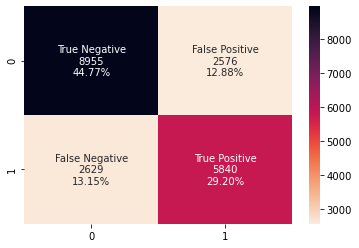

In [38]:
f1_for_KNN = model_evaluation(KNN_model)

In [286]:
f1_for_SVC = model_evaluation(SVC_model)

In [ ]:
f1_for_LR = model_evaluation(LR_model)

In [ ]:
f1_for_DT = model_evaluation(DT_model)

In [ ]:
f1_for_RF = model_evaluation(RF_model)

In [ ]:
f1_for_SGD = model_evaluation(SGD_model)

In [ ]:
f1_for_XGB = model_evaluation(XGB_model)

In [ ]:
f1_for_LGBM = model_evaluation(LGBM_model)